<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/08-interp/PDPbox_table_data_adult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NN13

[PDPbox_table_data_titanic.ipynb](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/master/05-NN/08-interp/PDPbox_table_data_titanic.ipynb)

In [1]:
!pip search pdpbox | grep INSTALLED || pip install pdpbox

  INSTALLED: 0.2.0 (latest)


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Activation, Dropout

from sklearn.base import BaseEstimator, TransformerMixin

from pdpbox import pdp, get_dataset, info_plots

Using TensorFlow backend.


## [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult "UCI Machine Learning Repository: Adult Data Set")

In [0]:
adult_cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
              'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',
              'native-country', 'income']

raw_train = pd.read_csv('./adult.data', index_col=False, names=adult_cols)
raw_train['is_test'] = 0
raw_test = pd.read_csv('./adult.test', index_col=False, skiprows=1, names=adult_cols)
raw_test['is_test'] = 1

In [5]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 16 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
is_test           32561 non-null int64
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


In [6]:
raw_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education-num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital-gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital-loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours-per-week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0
is_test,32561.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [7]:
raw_train.describe(exclude=np.number).T

,count,unique,top,freq
workclass,32561,9,Private,22696
education,32561,16,HS-grad,10501
marital-status,32561,7,Married-civ-spouse,14976
occupation,32561,15,Prof-specialty,4140
relationship,32561,6,Husband,13193
race,32561,5,White,27816
sex,32561,2,Male,21790
native-country,32561,42,United-States,29170
income,32561,2,<=50K,24720


In [8]:
raw_train.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,is_test
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,0
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,0
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K,0


In [9]:
raw_train['income'].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

In [10]:
raw_test['income'].value_counts()

 <=50K.    12435
 >50K.      3846
Name: income, dtype: int64

In [0]:
all_data = pd.concat((raw_train, raw_test), axis=0)

all_data = all_data.reset_index(drop=True)

In [12]:
all_data['income'].value_counts()

 <=50K     24720
 <=50K.    12435
 >50K       7841
 >50K.      3846
Name: income, dtype: int64

In [13]:
all_data['target'] = 1.
all_data['target'][all_data['income'].str.contains('<')] = 0.

all_data = all_data.drop(['income'], axis=1)

all_data['target'].value_counts()

0.0    37155
1.0    11687
Name: target, dtype: int64

In [14]:
cat_cols = all_data.select_dtypes(exclude=np.number).columns.values

cat_cols

array(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'], dtype=object)

In [15]:
num_cols = all_data.select_dtypes(include=np.number).columns.values[:-2]

num_cols

array(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'], dtype=object)

In [0]:
for c in cat_cols:
    all_data[c] = all_data[c].str.strip()

proc_data = pd.get_dummies(all_data, columns=cat_cols, drop_first=False)
proc_train = proc_data[proc_data['is_test'] == 0]
proc_test = proc_data[proc_data['is_test'] == 1]

In [17]:
proc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Columns: 110 entries, age to native-country_Yugoslavia
dtypes: float64(1), int64(7), uint8(102)
memory usage: 7.7 MB


In [0]:
X_train = proc_train.drop(['target', 'is_test'], axis=1)
y_train = proc_train['target']

X_test = proc_test.drop(['target', 'is_test'], axis=1)
y_test = proc_test['target']

In [19]:
y_train.value_counts()

0.0    24720
1.0     7841
Name: target, dtype: int64

In [20]:
y_test.value_counts()

0.0    12435
1.0     3846
Name: target, dtype: int64

In [0]:
def create_model():
    model = Sequential()
    model.add(Dense(input_shape=(proc_data.shape[1]-2, ), units=512))

    model.add(Activation('tanh'))
    model.add(Dropout(0.33))

    model.add(Dense(units=512))
    model.add(Activation('tanh'))
    model.add(Dropout(0.33))

    model.add(Dense(units=1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])
    
    return model

In [22]:
model = create_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               55808     
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)  

In [23]:
history = model.fit(X_train, y_train, verbose=2, epochs=5, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 32561 samples, validate on 16281 samples
Epoch 1/5
 - 7s - loss: 0.5796 - acc: 0.7533 - val_loss: 0.5376 - val_acc: 0.7834
Epoch 2/5
 - 6s - loss: 0.5628 - acc: 0.7639 - val_loss: 0.5664 - val_acc: 0.7871
Epoch 3/5
 - 6s - loss: 0.5599 - acc: 0.7685 - val_loss: 0.5517 - val_acc: 0.7868
Epoch 4/5
 - 5s - loss: 0.5529 - acc: 0.7719 - val_loss: 0.5135 - val_acc: 0.7887
Epoch 5/5
 - 5s - loss: 0.5462 - acc: 0.7783 - val_loss: 0.5393 - val_acc: 0.7912


## [pdpbox.pdp.pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html "pdpbox.pdp.pdp_isolate"), [pdpbox.pdp.pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html "pdpbox.pdp.pdp_plot")

In [0]:
def pdp_isolate_feature(model, dataset, numeric_feature, frac_lines_to_plot=0.2, figsize=(12, 8)):
    pdp_isolate_out = pdp.pdp_isolate(model=model, dataset=dataset, model_features=dataset.columns, feature=numeric_feature)
    fig, axes = pdp.pdp_plot(pdp_isolate_out, numeric_feature,
                             plot_params = {'title': f'PDP for numeric feature "{numeric_feature}"'},
                             figsize=figsize)
    fig, axes = pdp.pdp_plot(pdp_isolate_out, numeric_feature, 
                             plot_lines=True, frac_to_plot=frac_lines_to_plot, plot_pts_dist=True, 
                             plot_params = {'title': f'PDP for numeric feature "{numeric_feature}" ({frac_lines_to_plot*100:.0f}% lines + pts distribution)'},
                             figsize=figsize)

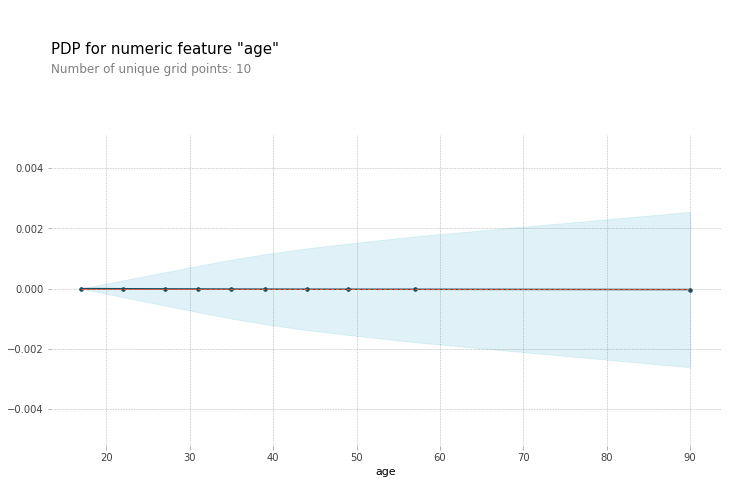

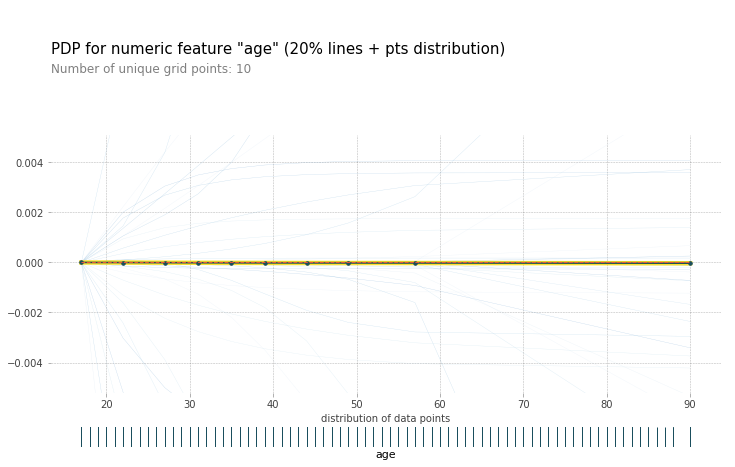

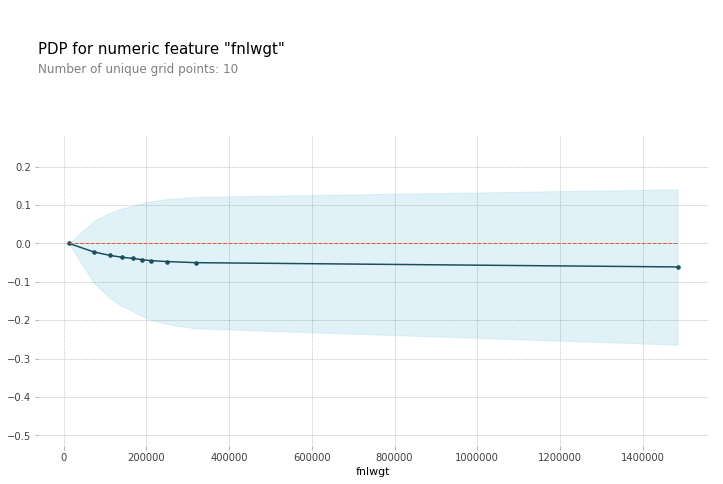

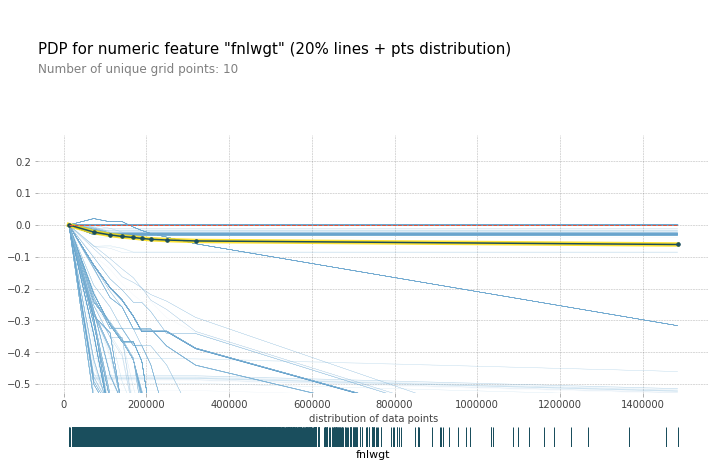

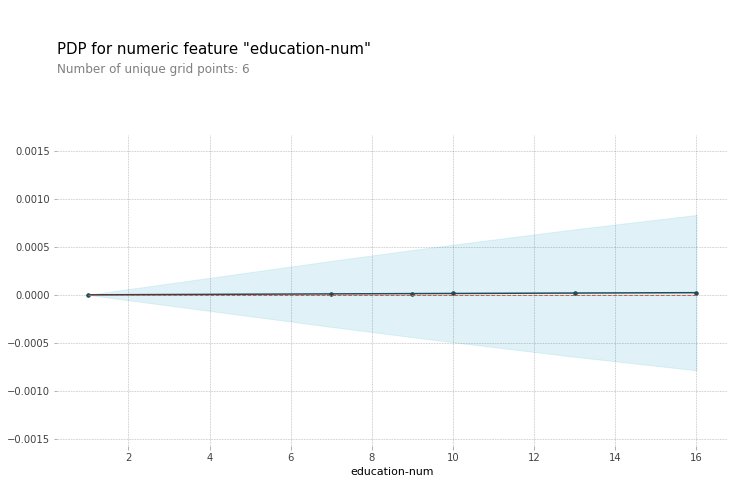

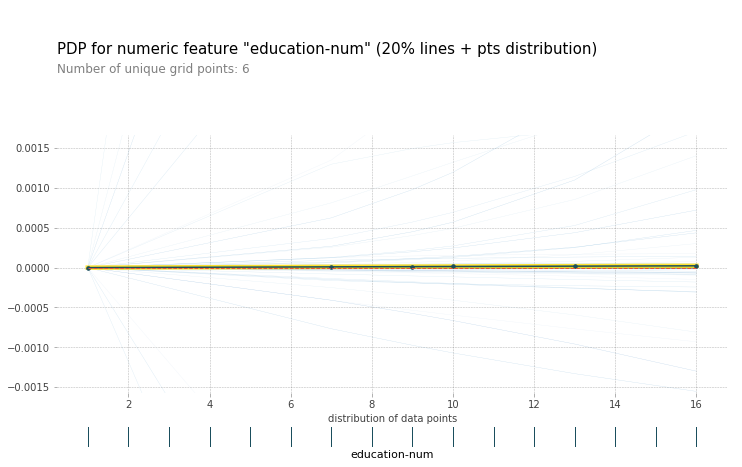

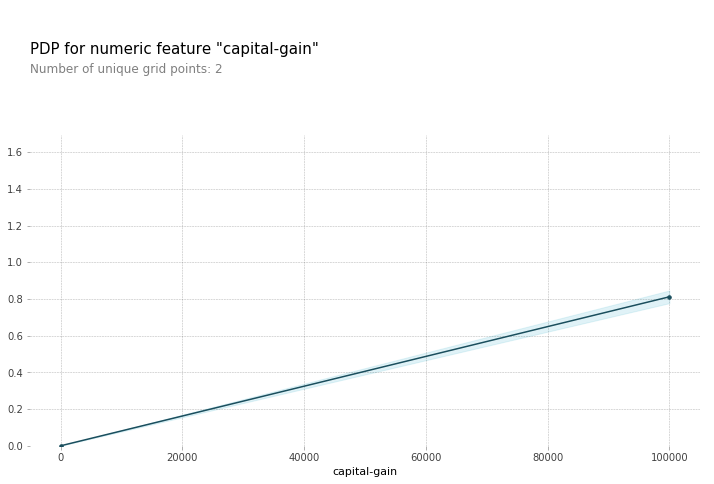

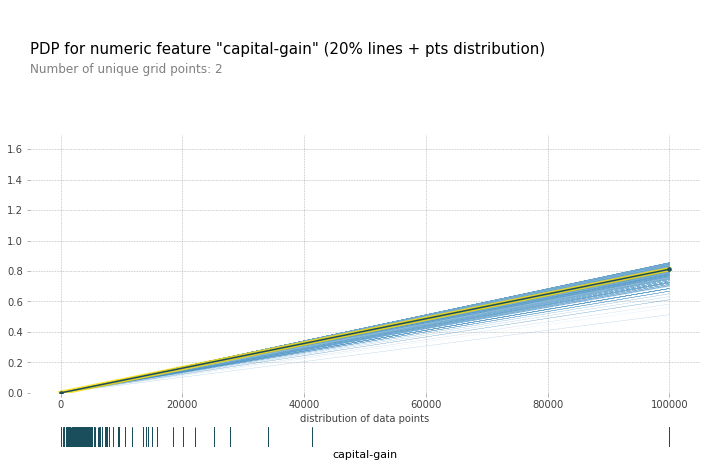

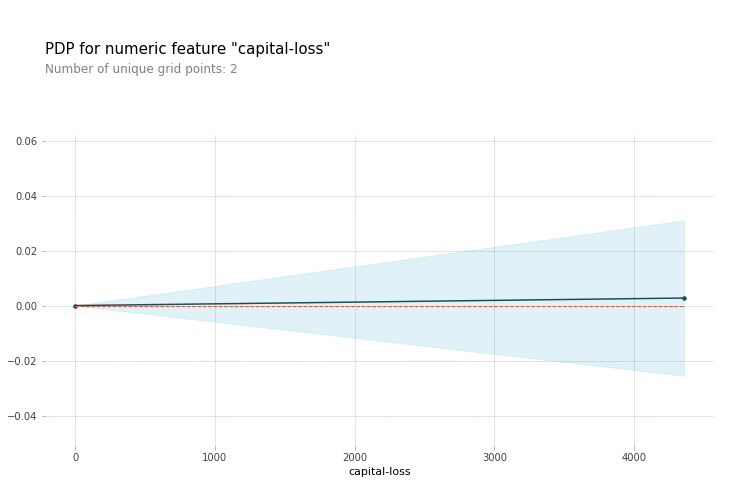

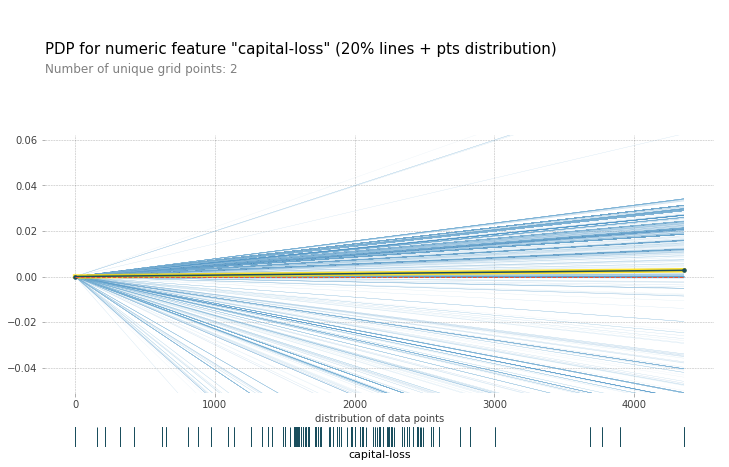

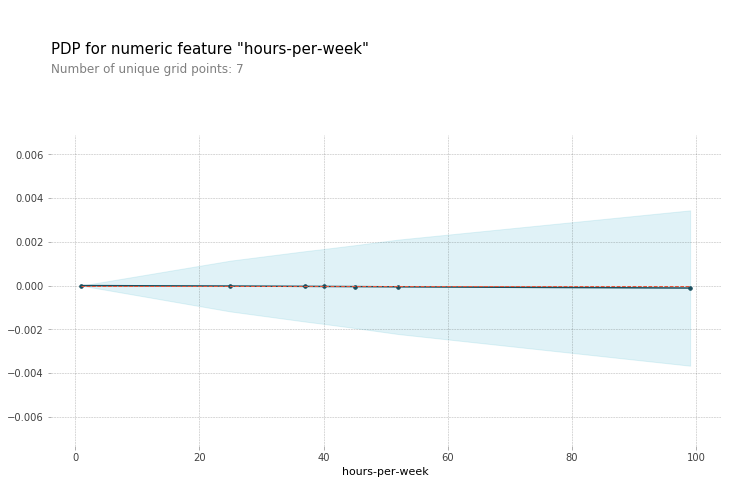

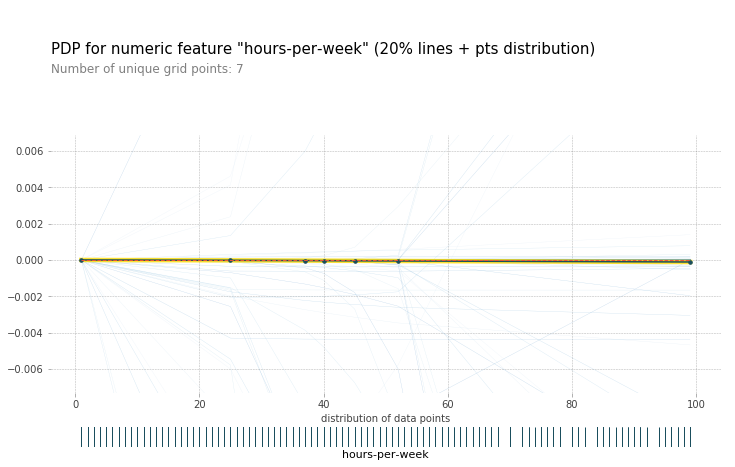

In [25]:
for feature in num_cols:
    pdp_isolate_feature(model, X_train, feature)

## [pdpbox.info_plots.actual_plot](https://pdpbox.readthedocs.io/en/latest/actual_plot.html "pdpbox.info_plots.actual_plot")

In [0]:
# Workaround 
class skl_model(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model=model
    def predict(self, X, par):
        return self.model.predict(X)

In [0]:
def pdp_info_plot(model, dataset, ohe_feature, figsize=(12, 8)):
    fig, axes, summary_df = info_plots.actual_plot(
        model=model, X=dataset, 
        feature=dataset.columns[dataset.columns.str.startswith(ohe_feature+'_')].tolist(), 
        feature_name=ohe_feature,
        plot_params={'title': f'Actual predictions plot for "{ohe_feature}"', 'xticks_rotation': 90},
        figsize=figsize,
        predict_kwds={'par' : 1}        
    )

\* *Распределение предсказаний на графиках для всех фич получилось не очень показательное (идентичное). Возможно, это связано с несбалансированностью классов в выборке?*

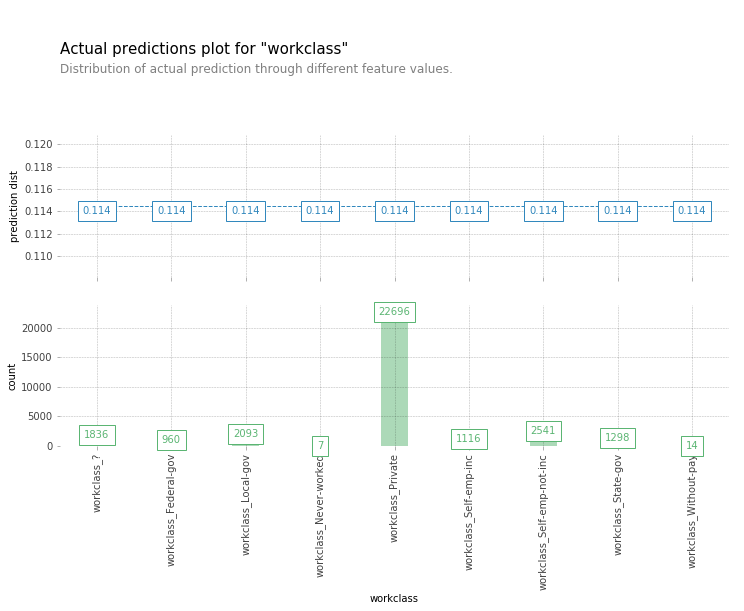

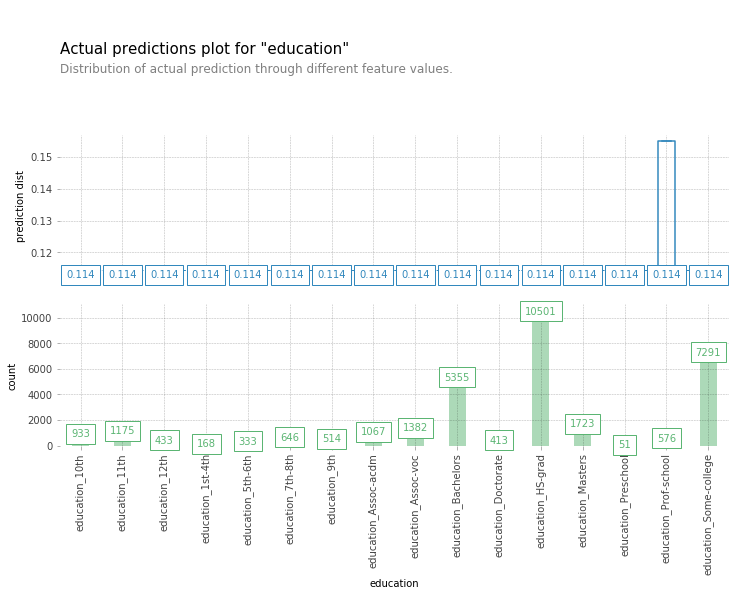

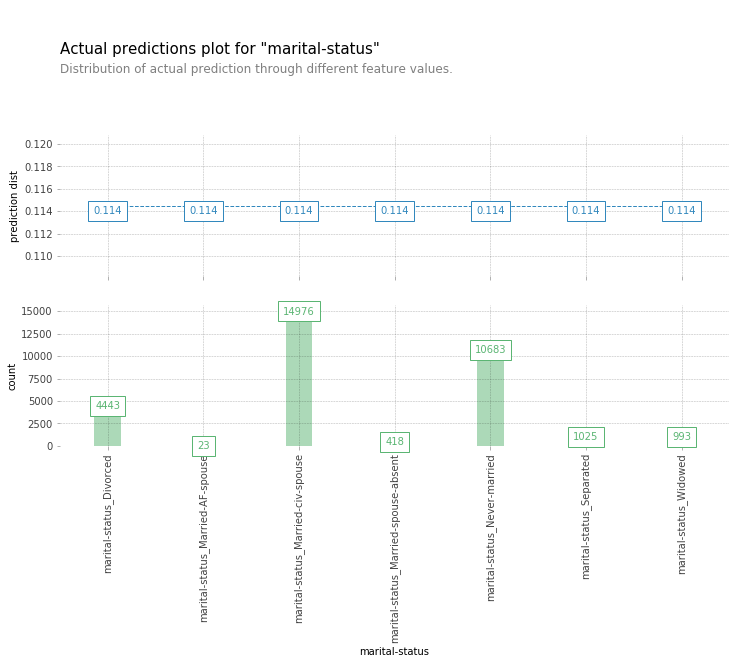

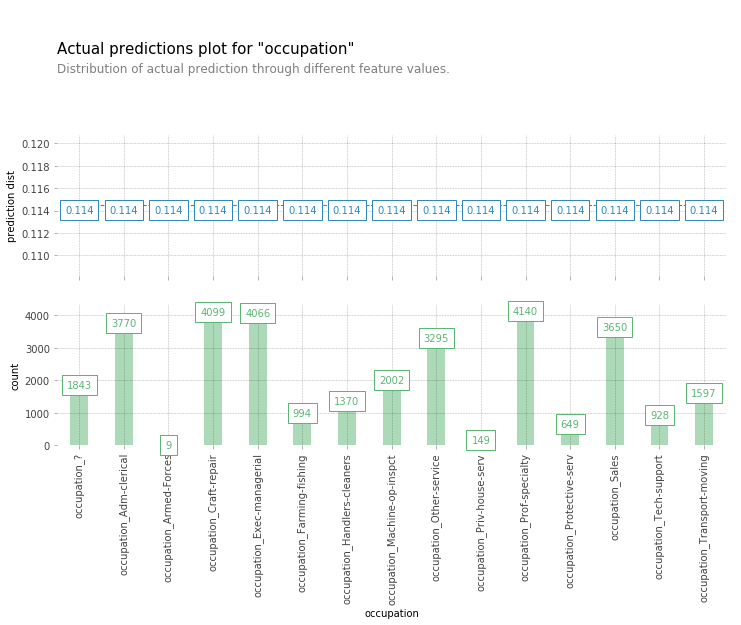

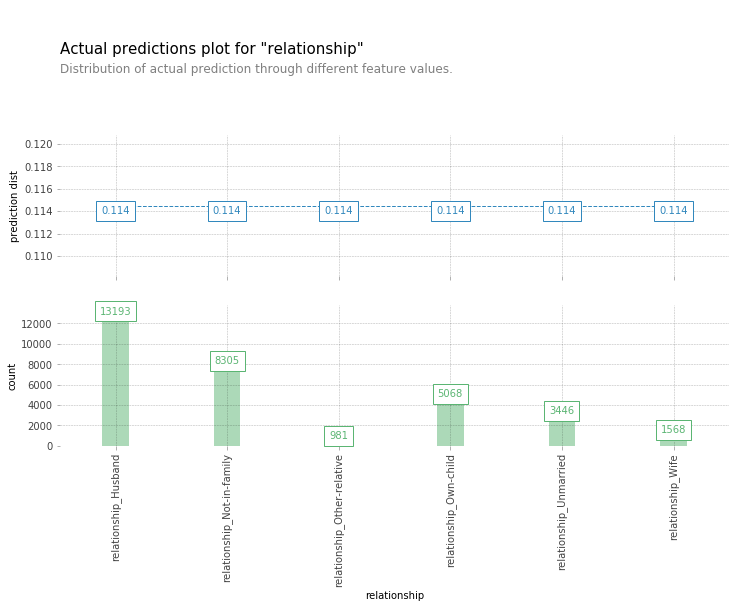

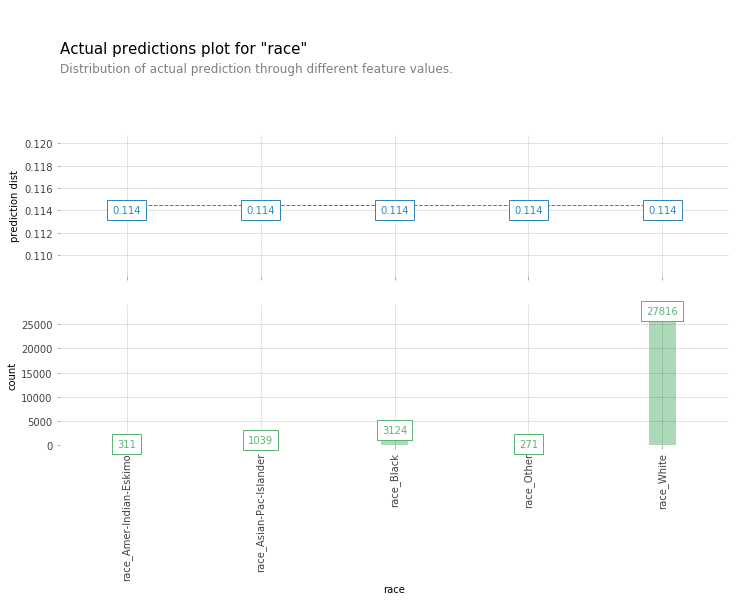

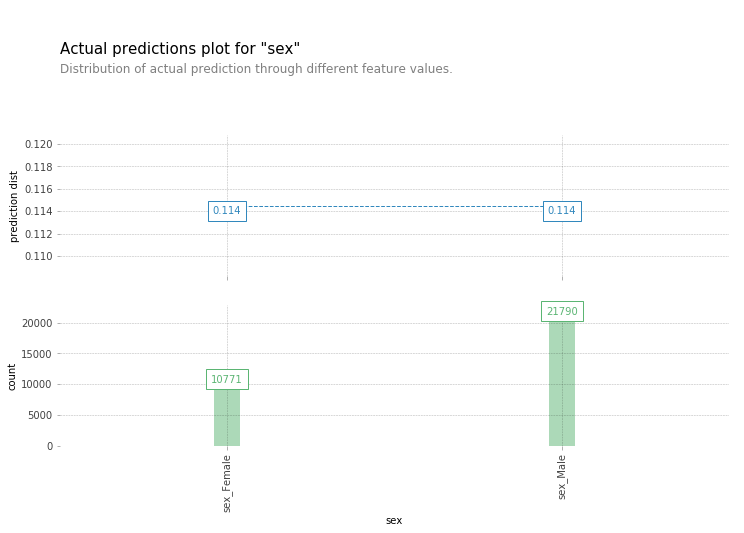

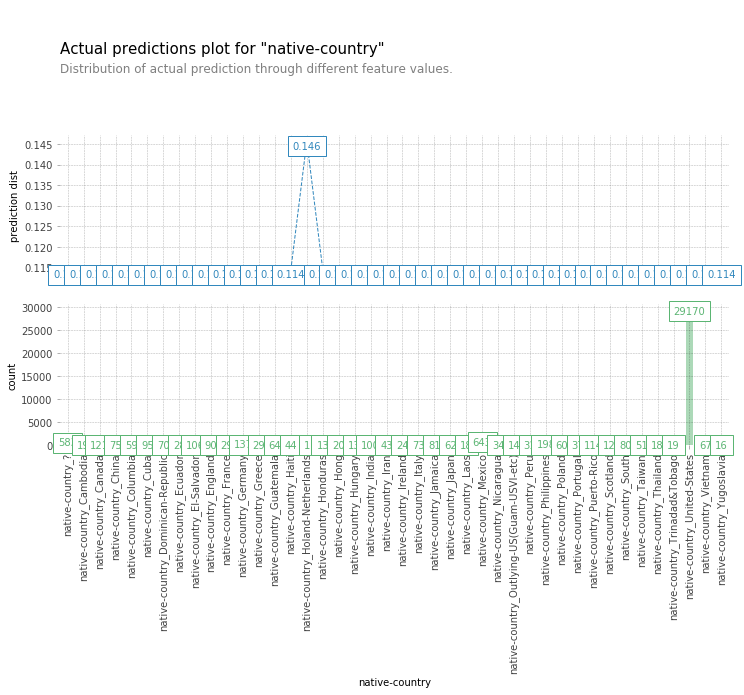

In [28]:
for feature in cat_cols:
    pdp_info_plot(skl_model(model), X_train, feature)

## [pdpbox.info_plots.actual_plot_interact](https://pdpbox.readthedocs.io/en/latest/actual_plot_interact.html "pdpbox.info_plots.actual_plot_interact")

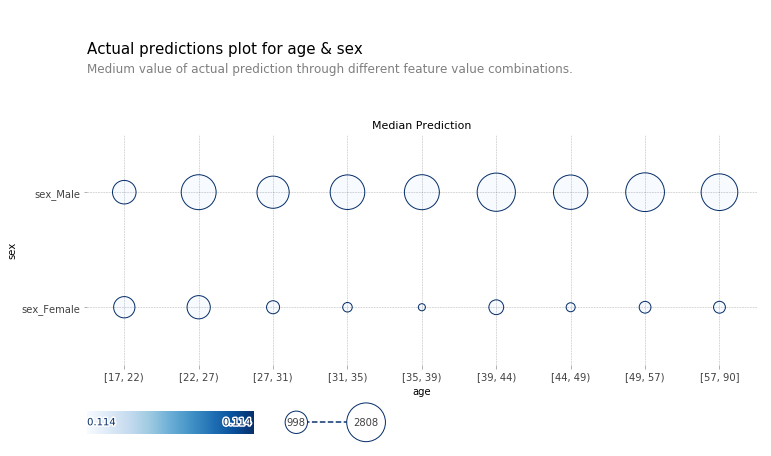

In [29]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=skl_model(model), X=X_train,
    features=['age', ['sex_Female','sex_Male']], feature_names=['age', 'sex'],
    figsize=(12, 8),
    predict_kwds={'par' : 1}
)